In [1]:
import segyio

segyfile = segyio.open("../Dutch F3 seismic data/Dutch Government_F3_entire_8bit seismic.segy", "r") 

In [2]:
import segyio

data = segyio.tools.cube("../Dutch F3 seismic data/Dutch Government_F3_entire_8bit seismic.segy")

In [3]:
import numpy as np

files = ['multi_else_ilxl.pts',
         'multi_grizzly_ilxl.pts',
         'multi_high_amp_continuous_ilxl.pts',
         'multi_high_amplitude_ilxl.pts',
         'multi_low_amp_dips_ilxl.pts',
         'multi_low_amplitude_ilxl.pts',
         'multi_low_coherency_ilxl.pts',
         'multi_salt_ilxl.pts',
         'multi_steep_dips_ilxl.pts']

path = "../Dutch F3 seismic data/"
logs = []
for f in files:
    logs.append(np.loadtxt(path + f))

In [4]:
istep = np.diff(segyfile.ilines[:2])[0]
istart = segyfile.ilines[0]

xstep = np.diff(segyfile.xlines[:2])[0]
xstart = segyfile.xlines[0]

zstep = np.diff(segyfile.samples[:2])[0]
zstart = segyfile.samples[0]

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.imshow(data[int((logs[0][0, 0] - istart) / istep)].T, cmap="gray")
for log in logs:
    plt.scatter((log[:, 1] - xstart) / xstep, (log[:, 2] - zstart) / zstep, alpha=0.005)
plt.ylabel("Depth")
plt.xlabel("X-line")
plt.show()

<Figure size 1200x1200 with 1 Axes>

In [6]:
slice_data = data[int((logs[0][0, 0] - istart) / istep)]

nlogs = []
for log in logs:
    nlogs.append(np.stack([(log[:, 1] - xstart) / xstep, (log[:, 2] - zstart) / zstep]).T)

In [7]:
weights = np.array([len(log) for log in nlogs])
nweights = weights / sum(weights)

In [ ]:
def make_data(slice_data, half_size):
    hs = half_size    
    slice_data_ext = np.pad(slice_data, ((3*half_size, 3*half_size - 1), (3*half_size, 3*half_size - 1)),
                            'symmetric')
    d_coord = np.zeros_like(slice_data_ext) + np.arange(len(slice_data_ext[0])) - 3*half_size
    x_coord = np.zeros_like(slice_data_ext) + np.arange(len(slice_data_ext)).reshape((-1, 1)) - 3*half_size
    
    all_stacked = np.stack([slice_data_ext[:-4*hs, 2*hs:-2*hs],
                            slice_data_ext[2*hs:-2*hs, 2*hs:-2*hs],
                            slice_data_ext[4*hs:, 2*hs:-2*hs:],
                            slice_data_ext[2*hs:-2*hs, :-4*hs],
                            slice_data_ext[2*hs:-2*hs, 2*hs:-2*hs],
                            slice_data_ext[2*hs:-2*hs, 4*hs:],
                            x_coord[2*hs:-2*hs, 2*hs:-2*hs],
                            d_coord[2*hs:-2*hs, 2*hs:-2*hs]], axis=-1)    
    return all_stacked

In [265]:
stacked_data = make_data(slice_data, half_size)

In [220]:
def batch_generator(stacked_data, logs, weights, batch_size, sample_half_size):
    batch = []
    hs = sample_half_size
    unique_labels = np.arange(len(logs))
    labels = np.random.choice(unique_labels, p=weights, size=batch_size)
    for i in labels:
        p = logs[i][np.random.randint(0, len(logs[i]))].astype(int)
        crop = stacked_data[p[0]:p[0] + 2*hs, p[1]:p[1] + 2*hs]
        batch.append(crop)
    return np.array(batch), labels

In [227]:
res = batch_generator(stacked_data, nlogs, nweights, 1, 12)

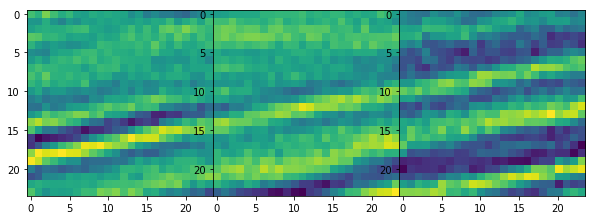

In [228]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10),)
ax[0].imshow(res[0][0, :, :, 0].T)
ax[1].imshow(res[0][0, :, :, 1].T)
ax[2].imshow(res[0][0, :, :, 2].T)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

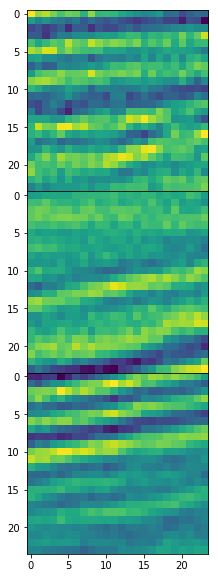

In [229]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10),)
ax[0].imshow(res[0][0, :, :, 3].T)
ax[1].imshow(res[0][0, :, :, 4].T)
ax[2].imshow(res[0][0, :, :, 5].T)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [230]:
import tensorflow as tf

config = tf.ConfigProto()
graph = tf.Graph()
with graph.as_default():
    images = tf.placeholder('float', shape=(None, 24, 24, 8), name='images')
    labels = tf.placeholder('float', shape=(None, len(nlogs)), name='labels')
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    conv = tf.layers.conv2d(images, 16, (3, 3), padding='same')
    conv = tf.layers.conv2d(conv, 16, (3, 3), padding='same')
    conv = tf.layers.batch_normalization(conv, momentum=0.9, training=is_training)
    conv = tf.nn.elu(conv)
    
    conv = tf.layers.conv2d(conv, 24, (3, 3), padding='same')
    conv = tf.layers.conv2d(conv, 24, (3, 3), padding='same')
    conv = tf.layers.batch_normalization(conv, momentum=0.9, training=is_training)
    conv = tf.nn.elu(conv)
    conv = tf.layers.max_pooling2d(conv, (2, 2), (2, 2))
    conv = tf.layers.dropout(conv, rate=0.1, training=is_training)
    
    conv = tf.layers.conv2d(conv, 32, (3, 3), padding='same')
    conv = tf.layers.conv2d(conv, 32, (3, 3), padding='same')  
    conv = tf.layers.batch_normalization(conv, momentum=0.9, training=is_training)
    conv = tf.nn.elu(conv)
    conv = tf.layers.max_pooling2d(conv, (2, 2), (2, 2))
    conv = tf.layers.dropout(conv, rate=0.1, training=is_training)
    
    conv = tf.layers.conv2d(conv, 48, (3, 3), padding='same')
    conv = tf.layers.conv2d(conv, 48, (3, 3), padding='same')
    conv = tf.layers.batch_normalization(conv, momentum=0.9, training=is_training)
    conv = tf.nn.elu(conv)
    conv = tf.layers.max_pooling2d(conv, (2, 2), (2, 2))
    conv = tf.layers.dropout(conv, rate=0.1, training=is_training)
#     print(conv.get_shape())
    
    flat = tf.layers.flatten(conv)
    
    logits = tf.layers.dense(flat, len(nlogs))    
    predict = tf.nn.softmax(logits)
#     print(predict.get_shape())

    loss = tf.losses.softmax_cross_entropy(labels, logits)

    optimizer = tf.train.AdamOptimizer()
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        step = optimizer.minimize(loss, var_list=train_vars)
    
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

In [232]:
import tqdm
nweights = weights / sum(weights)
batch_size = 100
half_size = 12

loss_history = []
for i in tqdm.tqdm(range(250)):
    x, y = batch_generator(stacked_data, nlogs, nweights, batch_size, half_size)
    ohe = np.zeros((batch_size, len(logs)))
    ohe[np.arange(batch_size), y] = 1
    res = sess.run([loss, step], feed_dict={images: x, labels: ohe, is_training: True})
    loss_history.append(res)

100%|██████████| 250/250 [01:28<00:00,  2.86it/s]


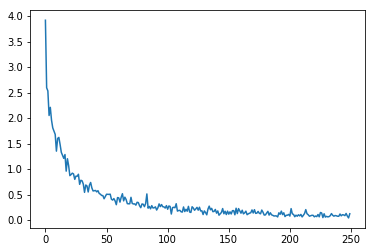

In [233]:
plt.plot(loss_history)
plt.show()

In [234]:
test_size = 1000
x, y = batch_generator(stacked_data, nlogs, nweights, test_size, half_size)
ohe = np.zeros((test_size, len(logs)))
ohe[np.arange(test_size), y] = 1
out = sess.run(predict, feed_dict={images: x, is_training: False})

In [235]:
from sklearn.metrics import classification_report

print(classification_report(y, np.argmax(out, axis=1)))

             precision    recall  f1-score   support

          0       0.76      0.94      0.84       156
          1       0.98      1.00      0.99       123
          2       1.00      0.58      0.73        97
          3       1.00      0.92      0.96        85
          4       0.94      1.00      0.97       132
          5       0.99      1.00      0.99       138
          6       1.00      0.99      1.00       146
          7       0.96      1.00      0.98        54
          8       1.00      0.94      0.97        69

avg / total       0.95      0.94      0.93      1000



In [236]:
def rolling_window_2d(a, shape):
    s = (a.shape[0] - shape[0] + 1,) + (a.shape[1] - shape[1] + 1,) + shape + a.shape[2:]
    strides = a.strides[:2] + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=s, strides=strides)

In [238]:
skip_step = 5

out_labels = []
for d in tqdm.tqdm(range(0, len(slice_data), skip_step)):
    x = rolling_window_2d(stacked_data[d: d + 2*hs], (2*hs, 2*hs))
    x = x.reshape((-1,) + x.shape[2:])[::skip_step]
    res = sess.run(predict, feed_dict={images: x, is_training: False})
    out_labels.extend(res)
predicted_slice = np.argmax(out_labels, axis=1).reshape(np.array(slice_data.shape) // skip_step + 1)

100%|██████████| 191/191 [00:18<00:00, 10.56it/s]


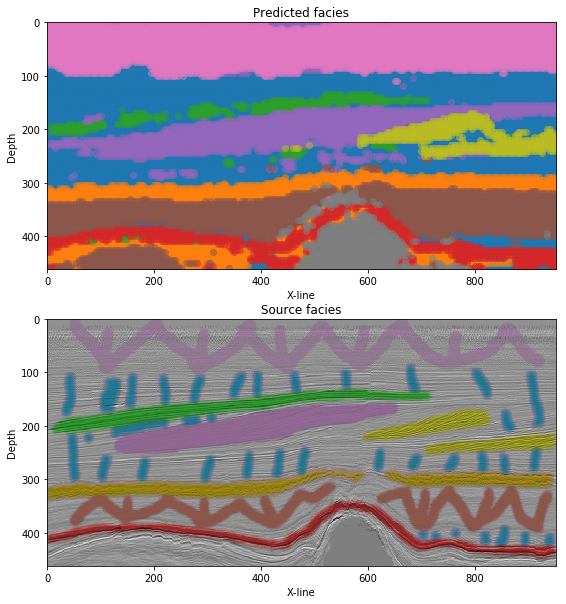

In [240]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

ax[0].set_title("Predicted facies")
ax[0].imshow(slice_data.T, cmap="gray")
for i in range(len(nlogs)):
    x, y = np.where(predicted_slice == i) 
    ax[0].scatter(x * skip_step, y * skip_step, alpha=0.5)
ax[0].set_ylabel("Depth"), ax[0].set_xlabel("X-line")
ax[0].set_xlim(0, slice_data.shape[0]), ax[0].set_ylim(slice_data.shape[1], 0)

ax[1].set_title("Source facies")
ax[1].imshow(data[int((logs[0][0, 0] - istart) / istep)].T, cmap="gray")
for log in logs:
    ax[1].scatter((log[:, 1] - xstart) / xstep, (log[:, 2] - zstart) / zstep, alpha=0.005)
ax[1].set_ylabel("Depth"), ax[1].set_xlabel("X-line")
ax[1].set_xlim(0, slice_data.shape[0]), ax[1].set_ylim(slice_data.shape[1], 0)

plt.show()

In [255]:
predict_3d = []
i_step = 50
skip_step = 10

for i in range(0, len(data), i_step):
    out_labels = []
    stacked = make_data(data[i], half_size)
    for d in tqdm.tqdm(range(0, len(slice_data), skip_step)):
        x = rolling_window_2d(stacked[d: d + 2*hs], (2*hs, 2*hs))
        x = x.reshape((-1,) + x.shape[2:])[::skip_step]
        res = sess.run(predict, feed_dict={images: x, is_training: False})
        out_labels.extend(res)
    predicted_slice = np.argmax(out_labels, axis=1).reshape(np.array(slice_data.shape) // skip_step + 1)
    predict_3d.append(predicted_slice)
predict_3d = np.array(predict_3d)

100%|██████████| 96/96 [00:05<00:00, 14.64it/s]


<IPython.core.display.Javascript object>


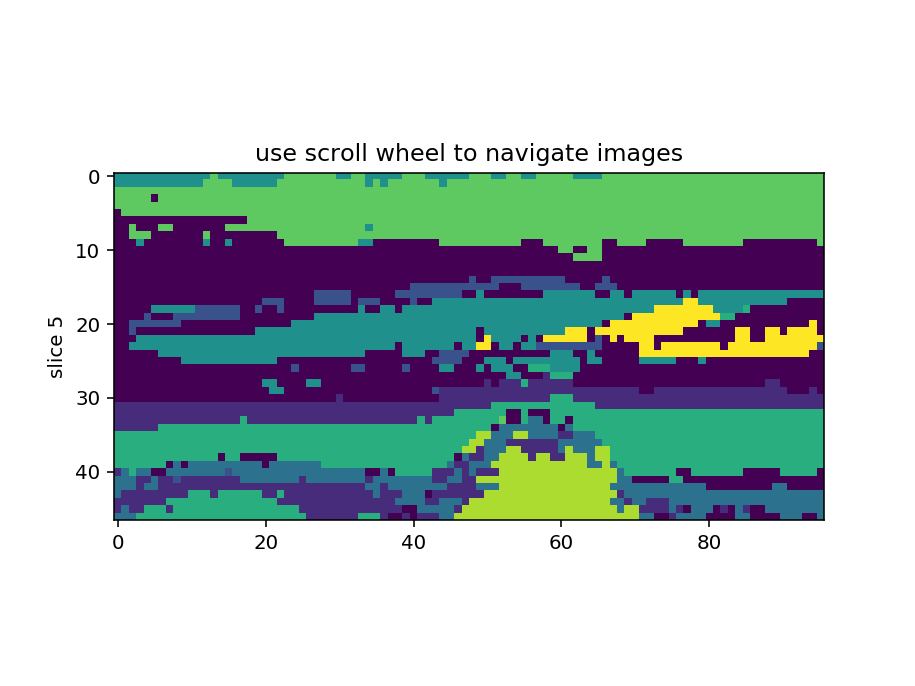

In [264]:
from .utils import IndexTracker

fig, ax = plt.subplots(1, 1)
X = np.transpose(predict_3d, (2, 1, 0))

tracker = IndexTracker(ax, X)

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()